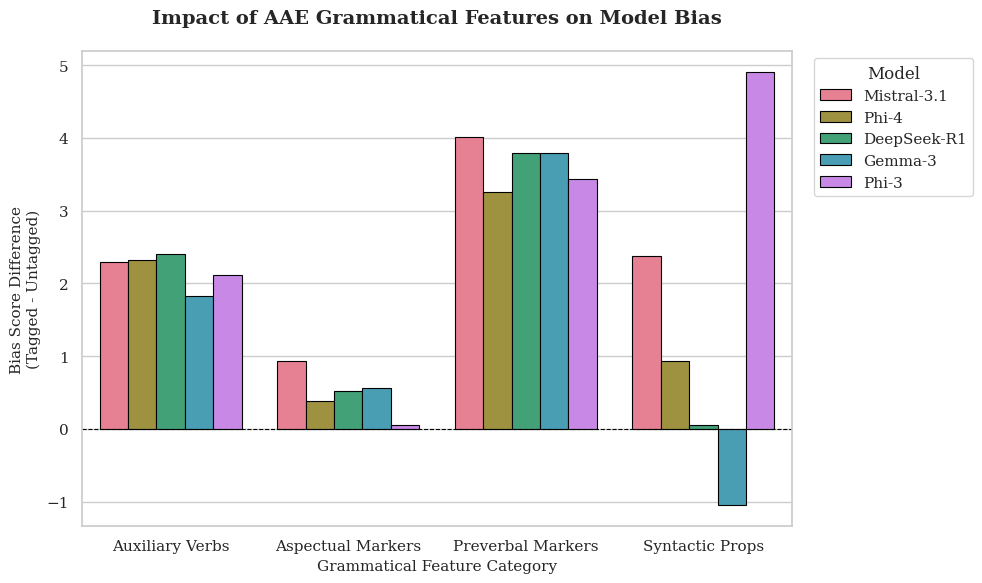

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===========================
# 1. 准备数据
# ===========================
# 假设你已经把每个模型的结果读取成了 DataFrame
# 这里我手动模拟你的数据格式，实际使用时请替换为 pd.read_csv
data = []

# 示例数据 (请把这里替换为你真实的 tagged_minus_Untagged 数值)
# 格式: (Model Name, Feature, Impact_Score)
models_data = {
    "Mistral-3.1": [2.30, 0.93, 4.01, 2.38], 
    "Phi-4":       [2.32, 0.38, 3.25, 0.93],
    "DeepSeek-R1": [2.41, 0.52, 3.79, 0.06], 
    "Gemma-3":     [1.83, 0.56, 3.79, -1.04], 
    "Phi-3":       [2.11, 0.06, 3.44, 4.90]  
}

features = ["Auxiliary Verbs", "Aspectual Markers", "Preverbal Markers", "Syntactic Props"]

# 构建合并的 DataFrame
for model, scores in models_data.items():
    for feat, score in zip(features, scores):
        data.append({"Model": model, "Feature": feat, "Bias Impact": score})

df_all = pd.DataFrame(data)

# ===========================
# 2. 画图
# ===========================
# 设置风格
sns.set_theme(style="whitegrid", font="serif") # 学术风格
plt.figure(figsize=(10, 6))

# 定义颜色 (与你之前的图保持一致性)
# 这里用不同深浅的蓝色/紫色来区分模型，或者用你之前的配色
palette = sns.color_palette("husl", len(models_data))

# 画图
ax = sns.barplot(
    data=df_all,
    x="Feature",
    y="Bias Impact",
    hue="Model",
    palette=palette,
    edgecolor="black", # 柱子边框
    linewidth=0.8
)

# ===========================
# 3. 美化
# ===========================
plt.title("Impact of AAE Grammatical Features on Model Bias", fontsize=14, fontweight='bold', pad=20)
plt.ylabel("Bias Score Difference\n(Tagged - Untagged)", fontsize=11)
plt.xlabel("Grammatical Feature Category", fontsize=11)
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc='upper left') # 图例放外侧
plt.axhline(0, color='black', linewidth=0.8, linestyle='--') # 0刻度线

plt.tight_layout()
plt.show()
# plt.savefig("feature_bias_impact.png", dpi=300)

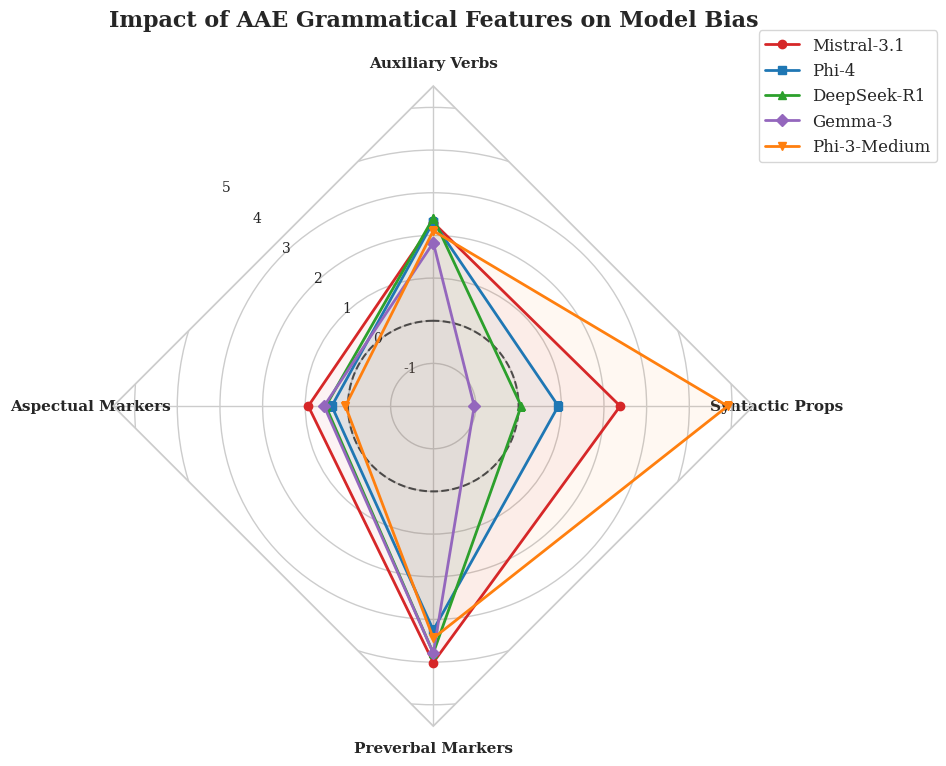

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# --- 1. 定义 Radar Chart 类 ---
def radar_factory(num_vars, frame='circle'):
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):
        name = 'radar'
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def fill(self, *args, **closed):
            return super().fill(closed=True, *args, **closed)

        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=11, fontweight='bold')

        def _gen_axes_patch(self):
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                spine = Spine(axes=self, spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

# --- 2. 数据准备 ---
models_data = {
    "Mistral-3.1": [2.30, 0.93, 4.01, 2.38], 
    "Phi-4":       [2.32, 0.38, 3.25, 0.93],
    "DeepSeek-R1": [2.41, 0.52, 3.79, 0.06], 
    "Gemma-3":     [1.83, 0.56, 3.79, -1.04], 
    "Phi-3-Medium":[2.11, 0.06, 3.44, 4.90]  
}

features = ["Auxiliary Verbs", "Aspectual Markers", "Preverbal Markers", "Syntactic Props"]
N = len(features)
theta = radar_factory(N, frame='polygon')

# --- 3. 绘图 ---
fig, ax = plt.subplots(figsize=(9, 8), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

colors = ['#d62728', '#1f77b4', '#2ca02c', '#9467bd', '#ff7f0e']
markers = ['o', 's', '^', 'D', 'v']

for i, (model, data) in enumerate(models_data.items()):
    ax.plot(theta, data, color=colors[i], label=model, linewidth=2, marker=markers[i], markersize=6)
    ax.fill(theta, data, facecolor=colors[i], alpha=0.05)

ax.set_varlabels(features)

# 设置网格，范围涵盖负值
ax.set_rgrids([-1, 0, 1, 2, 3, 4, 5], labels=['-1', '0', '1', '2', '3', '4', '5'], angle=45, fontsize=10)
ax.set_ylim(-2, 5.5)

# 0 基准线
ax.plot(np.linspace(0, 2*np.pi, 100), np.zeros(100), color='k', linestyle='--', linewidth=1.5, alpha=0.7, zorder=1)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12, frameon=True)

# *** 修改后的标题：回归最朴素的 "Impact... on Model Bias" ***
plt.title("Impact of AAE Grammatical Features on Model Bias", y=1.08, fontsize=16, fontweight='bold')

plt.show()